<a href="https://colab.research.google.com/github/nishantgovil03/Research/blob/master/LSTMWIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%pwd


'/content'

In [8]:
%ls 

drive/  sample_data/


In [9]:
%cd drive/MyDrive/

/content/drive/MyDrive


In [10]:
import pandas as pd

In [11]:
data = pd.read_csv("InputData.csv")

In [13]:
data['Summary']

0       <START> increase in the stamp duty threshold f...
1       <START> they are very much not for the good an...
2       <START> michael howard has denied his shadow c...
3       <START> the report said individual registratio...
4       <START> ukip roger has said he is glad to see ...
                              ...                        
4445    <START> india will allow domestic commercial a...
4446    <START> yukos says a us court was entitled to ...
4447    <START> house prices were higher on the year i...
4448    <START> rod ba chief said the results were res...
4449    <START> the commerce department said the trade...
Name: Summary, Length: 4450, dtype: object

In [15]:
data['Summary'][1]

'<START> they are very much not for the good and will destroy scotland regiments by moulding them into a single super regiment which will lead to severe recruitment a loss of local connections to those regiments and a loss to scotland of an important part of her heritage most her future the regiments are the envy of armies around the proposals to either merge or amalgamate the six regiments into a super regiment sparked a political with labour backbenchers and opposition politicians opposing the proposals include cutting scotland six regiments to five and merging these into a super in scotland last mr blair said the aim was to preserve tradition but introduce a more effective structure and hinted that a super regiment was committee of the army which is made up of the most senior defence will discuss plans for restructuring regiments on ahead of the expected army board a spokesman the government and the army board have spent the past four months attempting to trick serving soldiers and 

In [ ]:
!pip install attention

In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,Flatten,Dropout,BatchNormalization,Embedding,Input,TimeDistributed
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
#from attention import Attention

In [18]:
X_train,X_val,Y_train,Y_val=train_test_split(data['Article with stop words'],data['Summary'],test_size=0.3,random_state=29)
print(len(X_train),len(Y_train))
print(len(X_val),len(Y_val))

3115 3115
1335 1335


In [19]:
max_art_len=200
max_sum_len=50

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [21]:
article_tokenizer=Tokenizer(oov_token='<UNK>')
article_tokenizer.fit_on_texts(X_train)
tokenized_X_train=article_tokenizer.texts_to_sequences(X_train)
tokenized_X_val=article_tokenizer.texts_to_sequences(X_val)

art_vocab_size=len(article_tokenizer.word_index)+1

In [22]:
art_vocab_size

24225

In [23]:
padded_X_train=pad_sequences(tokenized_X_train,maxlen=max_art_len,padding='post',truncating='post')
padded_X_val=pad_sequences(tokenized_X_val,maxlen=max_art_len,padding='post',truncating='post')

In [24]:
print(padded_X_train.shape,padded_X_val.shape)

(3115, 200) (1335, 200)


In [25]:
summary_tokenizer=Tokenizer(oov_token='<UNK>')
summary_tokenizer.fit_on_texts(Y_train)
tokenized_Y_train=summary_tokenizer.texts_to_sequences(Y_train)
tokenized_Y_val=summary_tokenizer.texts_to_sequences(Y_val)

sum_vocab_size=len(summary_tokenizer.word_index)+1

In [26]:
sum_vocab_size

15775

In [27]:
padded_Y_train=pad_sequences(tokenized_Y_train,maxlen=max_sum_len,padding='post',truncating='post')
padded_Y_val=pad_sequences(tokenized_Y_val,maxlen=max_sum_len,padding='post',truncating='post')

In [28]:
print(padded_Y_train.shape,padded_Y_val.shape)

(3115, 50) (1335, 50)


In [29]:
embedding_size = 100
n_units = 300

In [23]:
#model = models.Sequential()
#model.add(layers.Dense(16, activation='relu',input_shape=(max_art_len,)))
#model.add(layers.Dense(16, activation='relu'))
#model.add(layers.Dense(16, activation='relu'))

In [30]:
max_text_len = max_art_len
x_voc = art_vocab_size
y_voc = sum_vocab_size 
latent_dim = n_units
embedding_dim=embedding_size

In [33]:
#K.clear_session()

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
#attn_layer = Attention(name='attention_layer')
#attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
#decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
#decoder_outputs = decoder_dense(decoder_concat_input)
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 100)     2422500     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 200, 300), ( 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
#encoder_inputs=Input(shape=(max_art_len,))
#encoder_emb=Embedding(art_vocab_size,embedding_size,trainable=True,name='Encoder_Embedding_layer')(encoder_inputs)
#encoder_lstm1=LSTM(n_units,return_sequences=True,return_state=True,name='Encoder_LSTM1')
#enclstm1_outputs,enclstm1_h,enclstm1_c=encoder_lstm1(encoder_emb)


#decoder_inputs=Input(shape=(None,))
#decoder_em=Embedding(sum_vocab_size,embedding_size,trainable=True,name='Decoder_Embedding_layer')
#decoder_emb=decoder_em(decoder_inputs)

#decoder_lstm1=LSTM(n_units,return_sequences=True,return_state=True,name='Decoder_LSTM1')
#declstm1_output,declstm1_h,declstm1_c=decoder_lstm1(decoder_emb,initial_state=[enclstm1_h,enclstm1_c])

#output_layer=TimeDistributed(Dense(sum_vocab_size,activation='softmax',name='softmax'))
#output=output_layer(declstm1_output)

#model=Model([encoder_inputs,decoder_inputs],output)

#model.summary()

In [31]:
plot_model(model,show_shapes=True)

NameError: ignored

In [34]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [35]:
history = model.fit([padded_X_train,padded_Y_train[:,:-1]],padded_Y_train[:,1:],
          epochs=1,
          validation_data=([padded_X_val,padded_Y_val[:,:-1]],padded_Y_val[:,1:]),
          batch_size=64)

49/49 [==============================] - 145s 3s/step - loss: 8.5580 - accuracy: 0.0578 - val_loss: 7.0440 - val_accuracy: 0.0671


In [36]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
import matplotlib.pyplot as plt

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [39]:
epochs = range(1,len(acc)+1)

<Figure size 432x288 with 0 Axes>

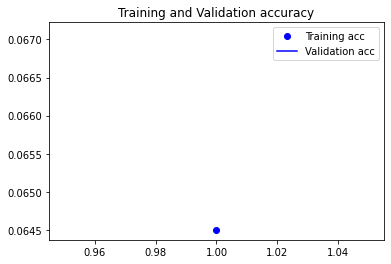

<Figure size 432x288 with 0 Axes>

In [40]:
plt.plot(epochs , acc , 'bo' ,  label = 'Training acc')
plt.plot(epochs , val_acc , 'b' ,  label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()


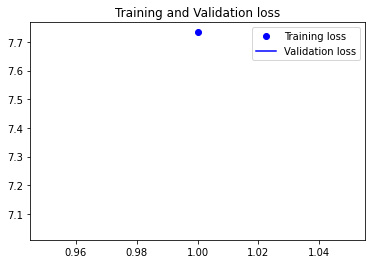

In [41]:
plt.plot(epochs , loss , 'bo' ,  label = 'Training loss')
plt.plot(epochs , val_loss , 'b' ,  label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


In [101]:
#infencoder_model=Model(inputs=[encoder_inputs],outputs=[enclstm1_outputs,enclstm1_h,enclstm1_c])

#infdecoder_model_state_input_h=Input(shape=(300,),name='infdec_I1')
#infdecoder_model_state_input_c=Input(shape=(300,),name='infdec_I2')

#infdeclstm1_output,infdec_h,infdec_c=decoder_lstm1(decoder_emb,initial_state=[infdecoder_model_state_input_h,infdecoder_model_state_input_c])

#infdec_output=output_layer(infdeclstm1_output)                         

#infdecoder_model=Model(inputs=[decoder_inputs]+[infdecoder_model_state_input_h,infdecoder_model_state_input_c],outputs=[infdec_output]+[infdec_h,infdec_c])

In [43]:
from tensorflow.keras.utils import plot_model

In [44]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
#attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
#decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
#decoder_outputs2 = decoder_dense(decoder_inf_concat) 
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

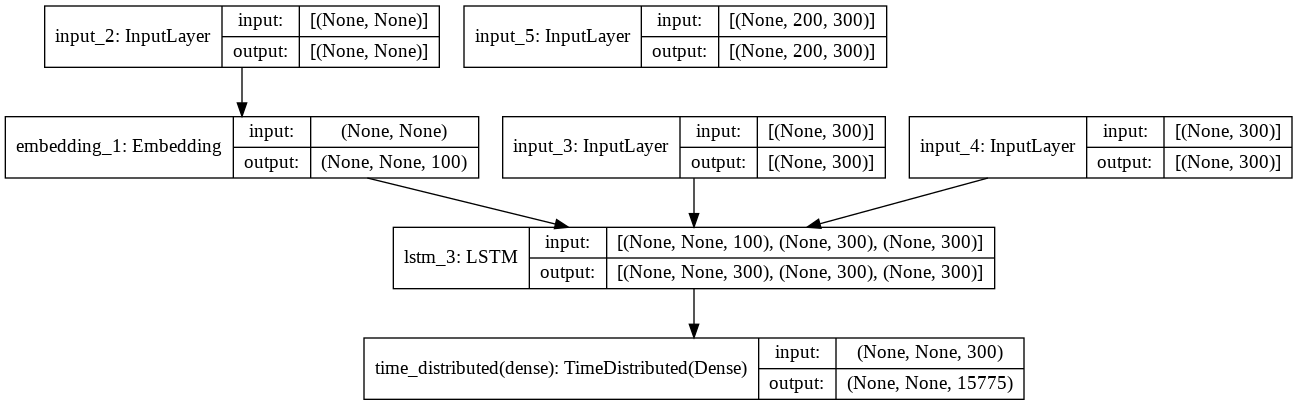

In [45]:
plot_model(decoder_model,show_shapes=True)

In [106]:
def decode_sequence(inp_seq):
    
    enc_out,enc_h,enc_c=infencoder_model.predict(inp_seq)
    
    tar_seq=np.zeros((1,1))
    tar_seq[0,0]=sum_wordindex['start']
    
    stop_loop=False
    decoded_string=''
    
    while not stop_loop:
       
        dec_out,dec_h,dec_c=infdecoder_model.predict([tar_seq]+[enc_h,enc_c])
        
        tar_token_index=np.argmax(dec_out[0,-1,:])
        tar_token_word=sum_wordindex[tar_token_index]
        
        if tar_token_word =='end' or len(decoded_string)>=max_art_len:
            
            stop_loop=True
        else:
            decoded_string+=tar_token_word
            
            tar_seq=np.zeros((1,1))
            tar_seq[0,0]=tar_token_index
            
            
            enc_h=dec_h
            enc_c=dec_c
            
    return decoded_string

In [50]:
reverse_art_index=article_tokenizer.index_word
reverse_sum_index=summary_tokenizer.index_word
sum_wordindex=summary_tokenizer.word_index
target_word_index = sum_wordindex
max_summary_len = max_sum_len


In [56]:
target_word_index['end']

16

In [82]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    print("max summary len is:- ", max_summary_len )
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token != '<END>'):
            decoded_sentence += ' '+sampled_token
        print("sampleo token being checked :-",decoded_sentence)
        print("decded sentence till now :-",sampled_token+"-----")
        print("decded sentence stripped :-",sampled_token.strip()+"---")
        # Exit condition: either hit max length or find stop word.
        if (sampled_token == '<END>'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [48]:
def seq2art(inp_seq):
    
    art=''
    
    for i in range(len(inp_seq)):
        
        if inp_seq[i]==0:
            break
        art+=reverse_art_index[inp_seq[i]]+' '
        
    return art


def seq2sum(inp_seq):
    
    summary=''
    
    for i in range(len(inp_seq)):
        
        if inp_seq[i]==0:
            break
        word=reverse_sum_index[inp_seq[i]]
        summary+=word+' '
            
    return summary

In [49]:
reverse_art_index=article_tokenizer.index_word
reverse_sum_index=summary_tokenizer.index_word
sum_wordindex=summary_tokenizer.word_index

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [59]:
reverse_target_word_index=reverse_sum_index
reverse_source_word_index=reverse_art_index
target_word_index=sum_wordindex

In [50]:
print('Example Articel : '+'\n',seq2art(padded_X_val[2]))
print('Example Summary : '+'\n',seq2sum(padded_Y_val[2]))


Example Articel : 
 lib dems stress budget trust gappublic trust in the handling of the economy can only be restored if gordon brown opens up his books for unbiased say the lib experts say there is a black hole in the public a claim denied by the lib dem spokesman vince cable said the public did not know who to believe and the national audit office should responding to the mr cable also attacked labour unfair and his mr brown insisted he was on course to meet his golden rule of borrowing only to rather than for over the course of the economic mr cable said people did not know whether to believe the chancellor or the consensus among experts which said the rule would be there is an issue of credibility and he we cannot have a continuation of a situation where the chancellor sets his own tests and then marks what we need is the equivalent of a thorough ofsted inspection of the government he asked what the government had to cable also accused the chancellor of ducking tough he there are se

In [51]:
import numpy as np

In [ ]:
padded_X_val[2]

In [119]:
enc_out,enc_h,enc_c=infencoder_model.predict(padded_X_val[2])
tar_seq=np.zeros((1,1))
tar_seq[0,0]=sum_wordindex['start']
    
stop_loop=False
decoded_string=''
    

In [ ]:
sum_wordindex['start']

In [ ]:
tar_seq

In [ ]:
enc_out.shape

In [ ]:
enc_h.shape

In [ ]:
enc_c.shape

In [140]:
dec_out,dec_h,dec_c=infdecoder_model.predict([tar_seq]+[enc_out,enc_h,enc_c])

ValueError: ignored

In [ ]:
print('Predicted Summary : '+'\n',decode_sequence([padded_X_val[2]]))

In [83]:
print("Predicted summary:",decode_sequence(padded_X_val[2].reshape(1,max_text_len)))

max summary len is:-  100
sampleo token being checked :-  the
decded sentence till now :- the-----
decded sentence stripped :- the---


KeyError: ignored